# Travelling Salesman Problem

## Statement of the problem

*Given $N$ cities and all the distances between them, what is the shortest path that passes by all the cities once and only once, and then go back to the original city? What is the distance travelled on the shortest path?*


### Brute force solution: enumeration of all the paths.

We enumerate and evaluate _all_ paths, and then select the shortest.
The decision tree for 4 cities, if we start from city 1, looks like this..

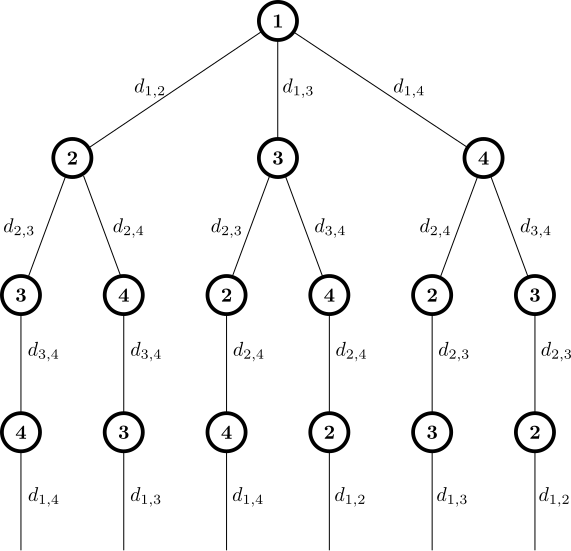

__Q:__ What is the number of all possible paths that start from and go back to a given city?

### Dynamic programming approach


#### What is Dynamic Programming?

Dynamic programming is a collection of algorithms used to compute _optimal strategies_ in presence of a _perfect model_!
So it is very powerful, but can be very computational intensive (which we often cannot afford) and need a perfect model of the environment (which we often do not have).

### What is THE nice property that the Salesman Problem has?

The Salesman Problem belongs to a class of problems which share a very useful property, that is that there is a perfectly well defined, well directed "flow" of the states towards an end position.

First, one can see that clearly a "good" path does not double back, so that every time you move, you have strictly one less city to visit. These allow us to divide the intermediate states of all path into _hierarchical levels_.

Secondly, one can start from the end position (I have visited all cities once) and "go backwards" by one city at the time, to construct all possible paths.

In Dynamic Programming we can find a fast, efficient way to solve the problem of finding the optimal solution in problems having this kind of property!


#### First: transforming the Travelling Salesman into a MDP.

We can cast the TSP into a Markov decision process (MDP), to which we can therefore apply the principle of dynamic programming.

We need:
1. a set of states $\mathcal{S}$;
2. for each state $s\in \mathcal{S}$, a set of available actions $\mathcal{A}_s$;
3. together, states and actions need to satisfy a Markovian dynamics, $(s_t,a_t) \to s_{t+1}$, with probability $p(s_{t+1}|s_t,a_t)$.


A minimal Markov-state representation is the following:

$$
   s=(k, A) \ ,
$$

where $k$ is the current city, and $A$ is the set of the cities that still need to be visited.
For a given state $s$ so represented, the action set then is

$$
    \mathcal{A}_s = A
$$

__Q:__ Why is $s=(k)$ not enough?

The Markov dynamics is deterministic

$$
    (s_t,a_t) = \big( (k, A), a \big) \to s_{t+1} = \big(a, A\backslash \{ a\} \big) \ .
$$

The decision making tree above, becomes

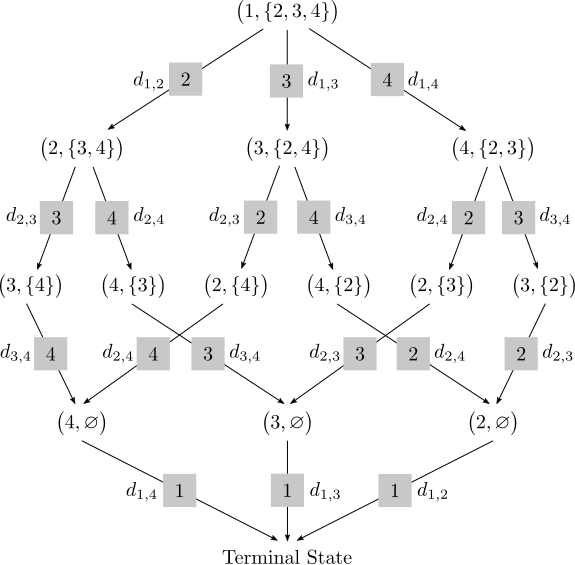



__Q:__ how much memory is required? How many states are there for $N$ cities? 

#### Dynamic programming and the Bellman equation

Dynamic programming finds the optimal path in the set of states $\mathcal{S}$, starting from the state $(1,\{2,\ldots N\})$ (only the origin is visited), and terminating in unique absorbing state (back to the origin, all city visited). 

__Q:__ Is the starting state special? Why?

From the computation of the optimal path in $\mathcal{S}$ one then trivially derives the path in the set of cities.

The idea of dynamic programming is to associate a *cost function* $C_\pi$ to each state in $\mathcal{S}$ that is the *the accumulated cost from that state to the end of the task, following the policy $\pi$*:

$$
    C_\pi(s) = \mathbb{E}_\pi\bigg[\sum_{t=0}^T d_{k_t, k_{t+1}} \, \bigg| \, s_0 = s \bigg]
$$


This object satisfies a recursive equation 

$$
    C_\pi\big(s=(k,A)\big) = \sum_{k'\in A} \pi(k'|s)\,\Big[ d_{k,k'} + C_\pi\big( k',A\backslash\{k'\}\big) \big) \Big]
$$

The *Bellman equation* for optimal cost function $C^*$ reads

$$
    C^*\big(k,A\big) = \min_{k'\in A} \big\{ d_{k,k'} + C^*\big(k',A\backslash\{k'\}\big) \big\}
$$

This equation has to be solved under the condition $C^*(k,\varnothing) = d_{k,1}$ (once no more cities are left to be visited, the only choice is to go back to the origin).

__How to compute the Optimal Cost?__

Iteratively! 
Since the optimal cost for having $0$ cities left to visit is known ($C^*(k,\varnothing) = d_{k,1}$) then we can compute the optimal cost for all states having $1$ city left to visit. This allows us to compute the optimal cost for all states with $2$ cities left to visit (because after an action they end up in states with $1$ city to visit)... and so on!

#### Calculating the optimal path

Once the optimal cost function $C^*$ has been calculated for all the states, the optimal path $k_0 = 0 \to k_1 \to\ldots\to k_N \to0$ can be computed iteratively via

$$
    k_{t+1} = {\rm argmin}_{k\in {A}_t}\Big\{ d_{k_t,k} + C^*\big(k, A_t\backslash\{k\} \big)\Big\}
$$

### Numerical solution

How to code such a problem?
A general idea is to try to separate (modularize) each task separately, to have different functions to solve each small part of the problem. 

Here, what do we want to do overall?
- Define the system: given the list of cities and the distances -> create all the MDP states and the cost of each action.
- Solve the problem iteratively.
-- starts calculating the optimal cost for all states with only zero cities left to visit (trivial, no choice).
-- Then calculate the optimal cost for all states with only one city left to visit (again, trivial, no choice).
-- Then calculate the optimal cost for all states with two cities left to visit (now, one has to choose!)
-- Then calculate the optimal cost for all states with three cities ...
-- So on until optimal cost has been calculated for all state!
- Find the optimal path, using the optimal cost.

How do we do it? Define different functions:

*build_states(N_cities)*
A function that is given the number of cities and produces the list of states.

*build_rand_dist_mat(N_cities)*
A function that is given the number of cities and produces the - random - distances between them.

*solve_TSP(dist_mat)*
This is the main task of the project: Finding the optimal cost for all states, iteratively.


#### Definitions

In [1]:
import numpy as np

In [4]:
def build_states(N_cities):
    """
    Builds the state space as a list of lists, where the first index runs 
    over the number of visited cities, and the second contains the state
    in the form: "(current_city, (city_to_visit_1, city_to_visit_2, ...))"
    """
    
    # First state: All other cities unvisited!
    states = [ [(0, tuple([i for i in range(1,N_cities)]))] ]
    
    # EXAMPLE: if N_cities = 4
    # states = [[(0, (1, 2, 3))]]
    
    #Cycle on how many cities already visited.
    for n_visited_cities in range(N_cities-1):
        states_at_n = [] 
        
        # States[-1] is list with all states with (n_visited_cities-1) visited cities
        # EXAMPLE: at the start
        # states[-1] = [(0, (1, 2, 3))]
        
        for state in states[-1]:
            
            # Choose one new city to visit.
            
            # EXAMPLE: at the start 
            # new_city = 1, 2 and 3
            
            for new_city in state[1]:
                new_cit_to_visit = set(state[1]) - set([new_city])
                new_state = ((new_city, tuple(new_cit_to_visit)))
                
                # EXAMPLE: at the start 
                # new_state = ((1, (2,3))
                
                # Check if it's not a duplicate
                if new_state not in states_at_n:
                    states_at_n.append(new_state)
        states.append(states_at_n)
    return states



def build_rand_dist_mat(N_cities, N_max=20, sym=True):
    """
    Build a squared random matrix of integers between 0 and N_max 
    of size N_cities. 
    """
    Ds = np.zeros((N_cities,N_cities), dtype=int)
    for i in range(N_cities-1):
        Ds[i,i+1:] = np.random.randint(0, N_max, size=(N_cities-i-1))

        # sym = Is travelling distance between A and B = distance between B and A?
        if sym:
            Ds[i+1:,i] = Ds[i,i+1:]
        else:
            Ds[i+1:,i] = np.random.rand(0, N_max, size=(N_cities-i-1))
    
    return Ds




print('State list example')
states_exe = build_states(7)

for n_visited_cit in range(len(states_exe)):
    print('States at {} visited cities: '.format(n_visited_cit), states_exe[n_visited_cit])

State list example
States at 0 visited cities:  [(0, (1, 2, 3, 4, 5, 6))]
States at 1 visited cities:  [(1, (2, 3, 4, 5, 6)), (2, (1, 3, 4, 5, 6)), (3, (1, 2, 4, 5, 6)), (4, (1, 2, 3, 5, 6)), (5, (1, 2, 3, 4, 6)), (6, (1, 2, 3, 4, 5))]
States at 2 visited cities:  [(2, (3, 4, 5, 6)), (3, (2, 4, 5, 6)), (4, (2, 3, 5, 6)), (5, (2, 3, 4, 6)), (6, (2, 3, 4, 5)), (1, (3, 4, 5, 6)), (3, (1, 4, 5, 6)), (4, (1, 3, 5, 6)), (5, (1, 3, 4, 6)), (6, (1, 3, 4, 5)), (1, (2, 4, 5, 6)), (2, (1, 4, 5, 6)), (4, (1, 2, 5, 6)), (5, (1, 2, 4, 6)), (6, (1, 2, 4, 5)), (1, (2, 3, 5, 6)), (2, (1, 3, 5, 6)), (3, (1, 2, 5, 6)), (5, (1, 2, 3, 6)), (6, (1, 2, 3, 5)), (1, (2, 3, 4, 6)), (2, (1, 3, 4, 6)), (3, (1, 2, 4, 6)), (4, (1, 2, 3, 6)), (6, (1, 2, 3, 4)), (1, (2, 3, 4, 5)), (2, (1, 3, 4, 5)), (3, (1, 2, 4, 5)), (4, (1, 2, 3, 5)), (5, (1, 2, 3, 4))]
States at 3 visited cities:  [(3, (4, 5, 6)), (4, (3, 5, 6)), (5, (3, 4, 6)), (6, (3, 4, 5)), (2, (4, 5, 6)), (4, (2, 5, 6)), (5, (2, 4, 6)), (6, (2, 4, 5)), (2, (3

In [3]:
def solve_TSP(dist_mat):
    
    N_cities = len(dist_mat)
    
    # Cost for each state
    costs = dict()
    # Best new city to go from each state
    best_path_d = dict()
    
    # Building the state space
    states = build_states(N_cities)
    
    # Imposing the boundary conditions
    for s in states[N_cities-1]:
        costs[s] = dist_mat[s[0]][0]
        best_path_d[s] = 0
    
    # Cycling over the number of visited cities (inverse order)
    for n_visit_cit in range(N_cities-2,-1,-1):

        for s in states[n_visit_cit]: # Cycling over the states with a fixed number of visited cities
            
            costs_at_s = [] # Cost of all the possible movements from s
            
            # s[1] contains the list of all cities I have yet to visit.
            # next_cit cycles over them
            
            for next_cit in s[1]:
        
                next_state = (next_cit, tuple(set(s[1]) - set([next_cit])))
                #                   distance from city to next  + known distance of best path onwards  
                costs_at_s.append(dist_mat[s[0]][next_state[0]] + costs[next_state])
            costs[s] = min(costs_at_s)
            best_path_d[s] = s[1][np.argmin(costs_at_s)]
            
    
    # Building the best path
    best_path = [0]
    s = states[0][0]
    next_cit = best_path_d[s]
    while next_cit != 0:
        best_path.append(next_cit)
        s = (next_cit, tuple(set(s[1]) - set([next_cit])))
        next_cit = best_path_d[s]
        
    return costs, best_path

In [9]:
N_cities = 13
dist_mat = build_rand_dist_mat(N_cities, sym=True)

print('Distance matrix. The first city is the first element:')
print(dist_mat)
print()

Distance matrix. The first city is the first element:
[[ 0  4 11  6  4 15  5 15  9  5  8  5  0]
 [ 4  0  8  0  9  0 12  5  6 16 10 17  5]
 [11  8  0  3  4  9  4 13 15 14  7 16  4]
 [ 6  0  3  0  4  0  8  7 18  8  7  8  8]
 [ 4  9  4  4  0 17  6  8 12 18  8  7  6]
 [15  0  9  0 17  0 17  9  6 12  2  3  5]
 [ 5 12  4  8  6 17  0  3  1  4 11 11 18]
 [15  5 13  7  8  9  3  0 19  5  4 13  4]
 [ 9  6 15 18 12  6  1 19  0 17  3 18 14]
 [ 5 16 14  8 18 12  4  5 17  0  9  6  8]
 [ 8 10  7  7  8  2 11  4  3  9  0 10 14]
 [ 5 17 16  8  7  3 11 13 18  6 10  0 14]
 [ 0  5  4  8  6  5 18  4 14  8 14 14  0]]


In [10]:
%time costs, best_path = solve_TSP(dist_mat)

print('\nNumber of states: ')
print(len(costs))
print('\nBest path: ')
print(best_path)
print('\nDistance to cover: ', )
print(costs[(0, tuple(i for i in range(1, N_cities)))])

CPU times: user 11.1 s, sys: 46.9 ms, total: 11.2 s
Wall time: 11.3 s

Number of states: 
24596

Best path: 
[0, 4, 2, 3, 1, 5, 11, 9, 6, 8, 10, 7, 12]

Distance to cover: 
36
